# Imports

In [133]:
import scipy.io as sio  # for loading matlab files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

# Fetching Dataset

Function - Organize Data and Flatten in Dataframe

Data from Supported Documentation

*    Link - https://cs.nyu.edu/~roweis/data.html
*    Grayscale Faces - 8 bit [0-255]
*    20 Different People
*    575 Total Images
*    Size - 112 x 92

Findings/Notes in Data Exploration

*    Dictionary When Loading
    *   "dirname" - classification per group of images
    *  "facedat" - groups of images per person
*    Values Stored/Wrapped in Object Array
        Third Value in Shapes Represent Instances of Image per Person
*    Classification Values are String Values; Converted to Numerical Values for Efficiency/Simplicity
*    Flattened Data Feature Length - 10304 (112 x 92)
*    Converted Data to Dataframe for Clarity
*    Appended Numerical Classification to Dataframe - "target"



In [134]:
def organizeData(file_path):
    
    # Import Data
    dataset = sio.loadmat(file_path)
    
    # Seperate Data (class/face position) 
    classification = dataset['dirnames']
    face_data = dataset['facedat']
    
    # Transform Classifications to Numerical
    for i in range(len(classification[0])):
        classification[0][i] = i
    
    # Create an empty list to append to dataframe later on
    face_data_list = []
    class_list = []
    
    
    # Grab Image and Classification Per Person
    for person_i in range(len(face_data[0])):                                                  # [0] -> Index to Get First Row to Access Data Directly
        print("==============================================================")
        print(f"Number of Images for Person {person_i}: {face_data[0][person_i].shape[2]}")                                                     
        
        for face_i in range(face_data[0][person_i].shape[2]):                                     
            # Verification and Visualization
            """
            print(face_data[0][person_i][:, :, face_i].shape)
            plt.imshow(face_data[0][person_i][:, :, face_i])
            plt.xticks([])
            plt.yticks([])
            plt.show()
            """
            # Append Data
            face_data_list.append(face_data[0][person_i][:, :, face_i].reshape(-1))             # Append Face Pics in Single Line
            class_list.append(str(classification[0][person_i]))                                 # Append Numerical Class Per Person

    
    data_org = pd.DataFrame(face_data_list)
    data_org['target'] = class_list

    return data_org

In [135]:
df_organized = organizeData('umist_cropped.mat')
df_organized.head()

Number of Images for Person 0: 38
Number of Images for Person 1: 35
Number of Images for Person 2: 26
Number of Images for Person 3: 24
Number of Images for Person 4: 26
Number of Images for Person 5: 23
Number of Images for Person 6: 19
Number of Images for Person 7: 22
Number of Images for Person 8: 20
Number of Images for Person 9: 32
Number of Images for Person 10: 34
Number of Images for Person 11: 34
Number of Images for Person 12: 26
Number of Images for Person 13: 30
Number of Images for Person 14: 19
Number of Images for Person 15: 26
Number of Images for Person 16: 26
Number of Images for Person 17: 33
Number of Images for Person 18: 48
Number of Images for Person 19: 34


,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,target
0,233,234,234,233,234,232,232,168,99,78,...,154,151,147,143,140,141,141,140,136,0
1,234,234,234,234,233,232,202,98,79,77,...,154,150,147,141,140,137,138,137,137,0
2,234,234,234,234,233,230,225,109,85,84,...,174,168,164,157,152,151,148,145,145,0
3,234,234,234,234,234,234,234,232,229,205,...,168,162,157,155,150,144,144,142,143,0
4,234,234,234,234,234,234,234,234,229,211,...,176,170,164,162,157,152,150,148,148,0


# Seperating Features and Dataset

In [136]:
target = df_organized["target"]
features = df_organized.drop("target", axis=1)

# Viewing Classes

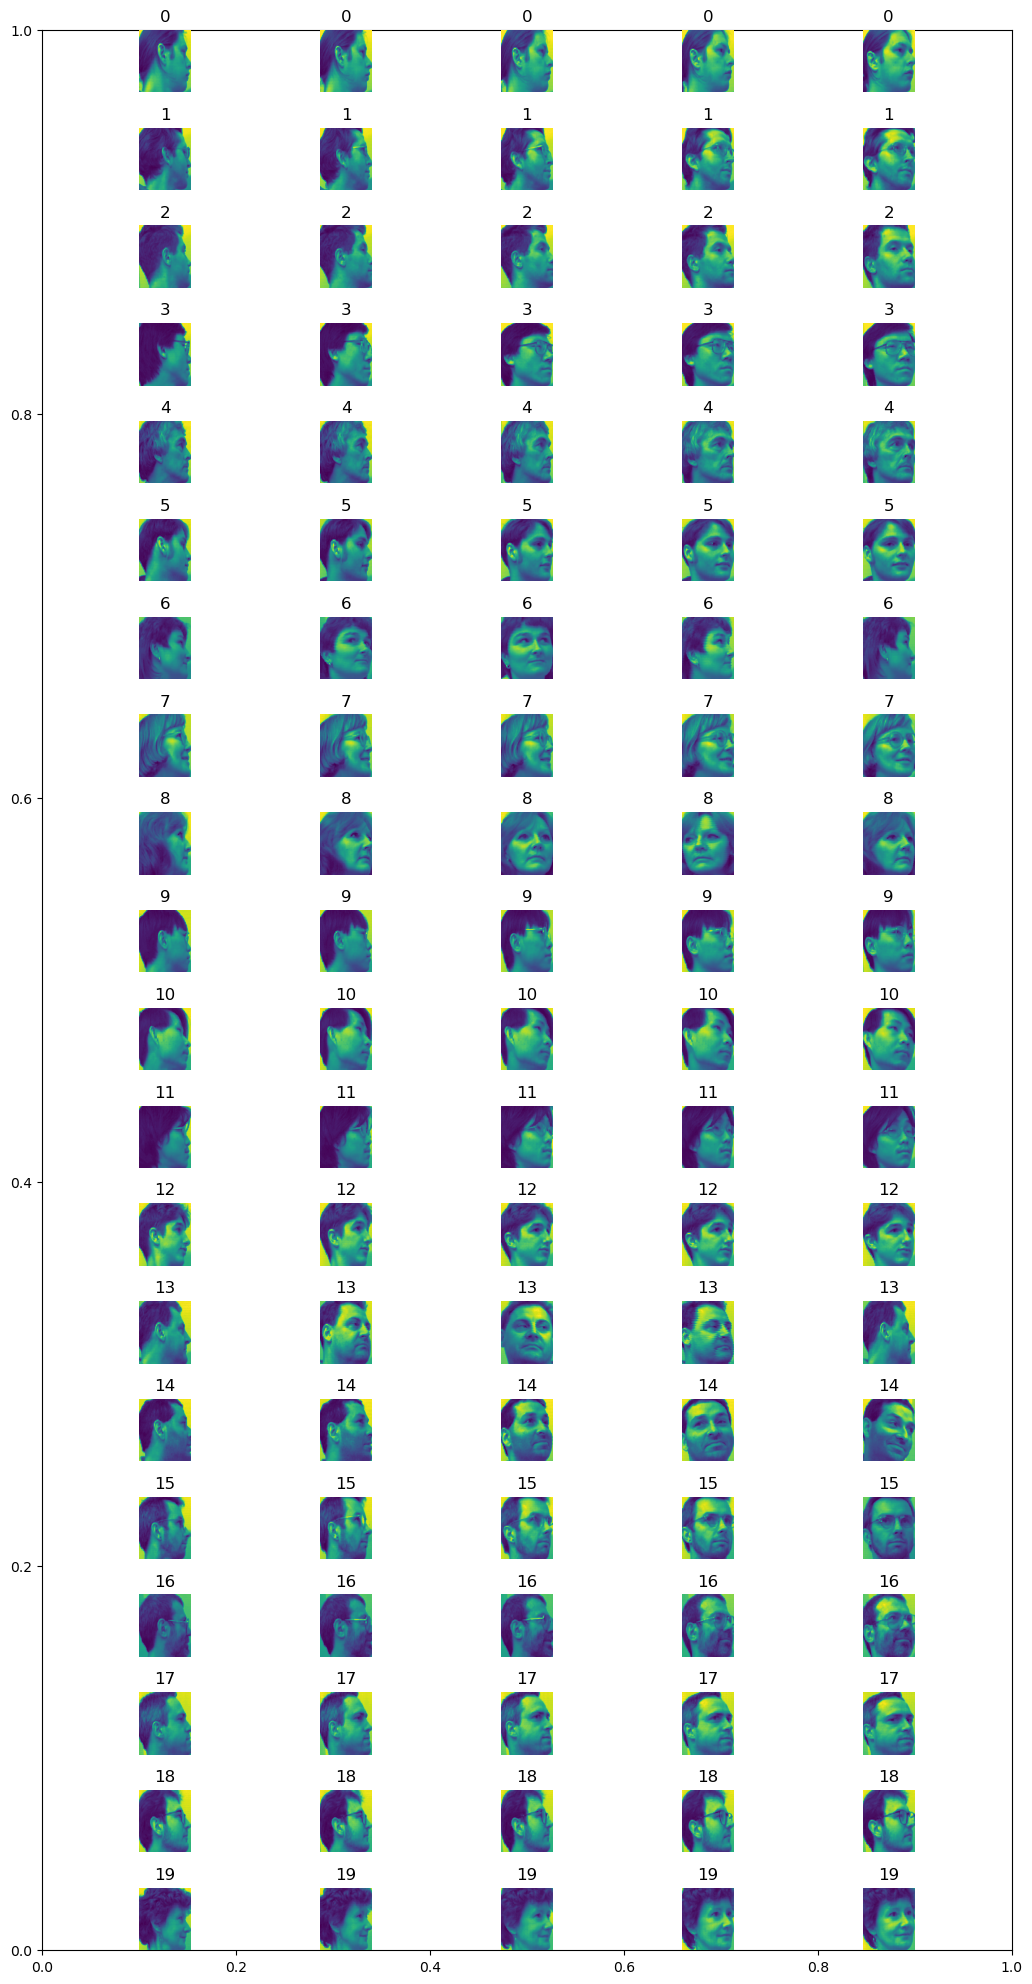

In [137]:
unique_target_var = pd.unique(target)
fig = plt.subplots(figsize=(10, 20))

grouped_indices = target.groupby(target).indices

plt_index = 0
test = None
for unique in unique_target_var:
    for num in [0, 4, 8, 12, 16]:
        plt_index += 1

        index_to_acess = grouped_indices[unique][num]
        
        plt.subplot(20, 5, plt_index) 
        
        
        plt.imshow(np.array(features.iloc[index_to_acess]).reshape(112, 92))
        plt.axis("off")
        plt.title(unique)

plt.tight_layout()
plt.show()

# Data Preprocessing

## Train-Test-Split: Stratified

In [138]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, stratify=target, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

## Pipeline
* Edit ~ Standard Scaler is applied first before PCA dimensionality reduction is performed due to PCA emphasizing in bigger values (outliers) and therefore Standard Scaler is applied first to standardize these outliers.
    * Standard Scaler - Reducing Values and Outliers
    * PCA - Feature Dimensionality Reduction
* kMeans - Feature Engineering

In [139]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA(0.99))
    ]
)

## Getting Best Number of Clusters

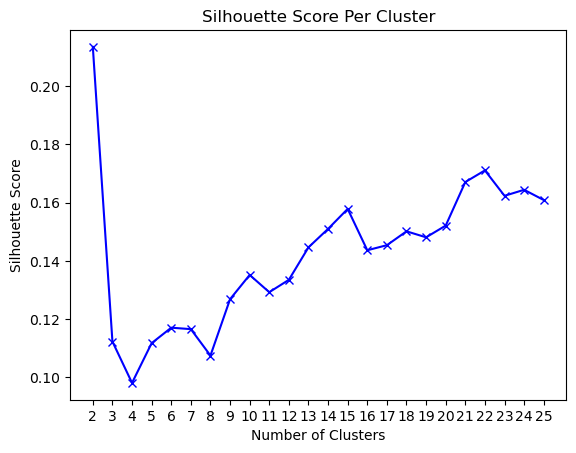

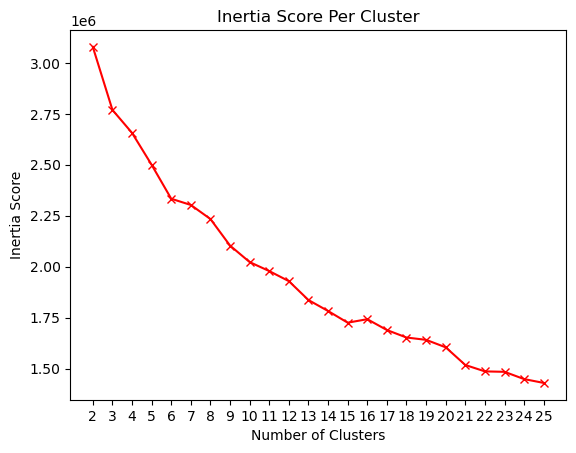

In [140]:
def best_kmeans_nclusters_pipe(pipeline, features, testing_range):
    processed_feat = pipeline.fit_transform(features)
    
    # Get List of Sil Scores
    sil_score_list = [silhouette_score(processed_feat, KMeans(n_clusters=num, random_state=42).fit(processed_feat).labels_) for num in testing_range]
    intertia_score_list = [KMeans(n_clusters=num, random_state=42).fit(processed_feat).inertia_ for num in testing_range]
   
    # Plot Silhouette Scores
    plt.plot(testing_range, sil_score_list, 'bx-')
    plt.xticks(testing_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score Per Cluster")
    plt.show()

    # Plot Inertia Scores
    plt.plot(testing_range, intertia_score_list, 'rx-')
    plt.xticks(testing_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia Score")
    plt.title("Inertia Score Per Cluster")
    plt.show()
    
best_kmeans_nclusters_pipe(pipe, x_train, range(2, 26))

# MLP Evaluating Function

In [141]:
# Function for MLP Metric Analysis
def model_metric_analyze(classification, prediction):
  ac_score = accuracy_score(classification, prediction)
  pr_score = precision_score(classification, prediction, average="weighted")
  re_score = recall_score(classification, prediction, average="weighted")
  f1_measure = f1_score(classification, prediction, average="weighted")
  cf_matrix = confusion_matrix(classification, prediction)

  custom_index = ['accuracy', 'precision', 'recall', 'f1', 'cf']
  df_scores = pd.Series([ac_score, pr_score, re_score, f1_measure, cf_matrix], index=custom_index)
  return df_scores

# Function for Outputting Metrics
def print_metrics(df_scores):
  print(f'Accuracy Score: {df_scores["accuracy"]}')
  print(f'Precision Score: {df_scores["precision"]}')
  print(f'Recall Score: {df_scores["recall"]}')
  print(f'F1 Score: {df_scores["f1"]}')

  labels = range(1, 21)
  sns.heatmap(df_scores['cf'], annot=True, fmt='d', cmap='flare', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted', fontweight='bold', fontsize=15)
  plt.ylabel('Actual', fontweight='bold', fontsize=15)
  plt.title('Confusion Matrix', fontweight='bold', fontsize=20)
  plt.show()

# Create Model

In [142]:
def create_mlp_model(input_shape, output_shape):
    base_model = Sequential()
    base_model.add(Dense(128, activation='relu', input_shape=input_shape))
    base_model.add(Dense(64, activation='relu'))
    base_model.add(Dense(len(output_shape), activation='softmax'))
    
    base_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    base_model.summary()

    return base_model

# Manually Choosing Best Number of Clusters and Comparing it on MLP
* 2 - Highest Silhouette Score
* 3 - To Test Based on Previous Results
* 6 - Elbow Method and Inertia
* 15 - Highest Value Sil Scores
* 20 - Number of True Classes
* 22 - Highest Value Sil Score

In [143]:
chosen_nums = [2, 3, 6, 15, 20, 22]

In [144]:
def num_cluster_search_mlp_results(pipeline, x_train, x_val, x_test, y_train, y_val, y_test, num_clusters):
    processed_x_train = pipeline.fit_transform(x_train)
    processed_x_val = pipeline.transform(x_val)
    processed_x_test = pipeline.transform(x_test)

    # Scores
    acc_scores = []
    # For every num in num_of_clusters
    for num in num_clusters:
        # KMeans Features and Labels
        k_means = KMeans(n_clusters=num)
        
        dist_feat_train = k_means.fit_transform(processed_x_train)
        dist_feat_val = k_means.transform(processed_x_val)
        dist_feat_test = k_means.transform(processed_x_test)
        
        cl_labels_train = k_means.labels_
        cl_labels_val = k_means.predict(processed_x_val)
        cl_labels_test = k_means.predict(processed_x_test)
        
        # New Training Features
        new_x_train = np.concatenate((processed_x_train, dist_feat_train, cl_labels_train.reshape(-1, 1)), axis=1)
        new_x_val = np.concatenate((processed_x_val, dist_feat_val, cl_labels_val.reshape(-1, 1)), axis=1)
        new_x_test = np.concatenate((processed_x_test, dist_feat_test, cl_labels_test.reshape(-1, 1)), axis=1)
        
        # One Hot Encode Labels
        ohe_y_train = tf.one_hot(y_train, depth=len(np.unique(y_train)))
        ohe_y_test = tf.one_hot(y_test, depth=len(np.unique(y_test)))
        ohe_y_val = tf.one_hot(y_val, depth=len(np.unique(y_val)))


        # Create Model
        model = create_mlp_model((new_x_train.shape[1],), y_train.unique())
        
        # Test Model
        model.fit(new_x_train, ohe_y_train, epochs=50, validation_data=(new_x_val, ohe_y_val))

        # Predict Data
        model_pred = model.predict(new_x_test)
        model_pred_single = np.argmax(model_pred, axis=1)

        test_single = np.argmax(ohe_y_test, axis=1)
        
        # Evaluate Data
        acc_scores.append(accuracy_score(test_single, model_pred_single))
        print_metrics(model_metric_analyze(test_single, model_pred_single))

    return acc_scores

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 128)               29056     
_________________________________________________________________
dense_253 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_254 (Dense)            (None, 20)                1300      
Total params: 38,612
Trainable params: 38,612
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 0s 12ms/step - loss: 9.9098 - accuracy: 0.1246 - val_loss: 5.4167 - val_accuracy: 0.2174
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 3.3749 - accuracy: 0.3652 - val_loss: 2.6180 - val_accuracy: 0.4957
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 1.2195 - accuracy: 0.6435 

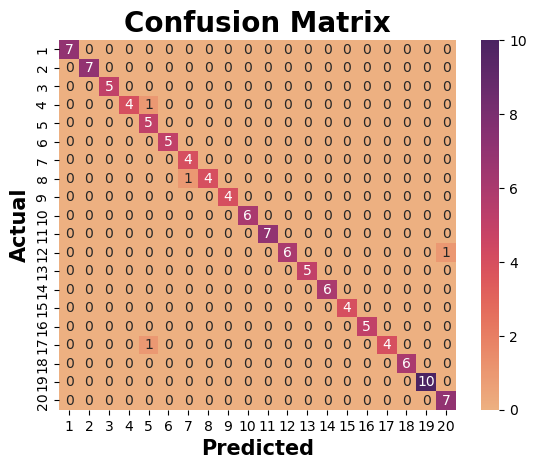

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_255 (Dense)            (None, 128)               29184     
_________________________________________________________________
dense_256 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_257 (Dense)            (None, 20)                1300      
Total params: 38,740
Trainable params: 38,740
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 0s 9ms/step - loss: 14.4409 - accuracy: 0.0870 - val_loss: 7.1403 - val_accuracy: 0.1652
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 5.7518 - accuracy: 0.2232 - val_loss: 3.5413 - val_accuracy: 0.3739
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 2.4013 - accuracy: 0.4435 

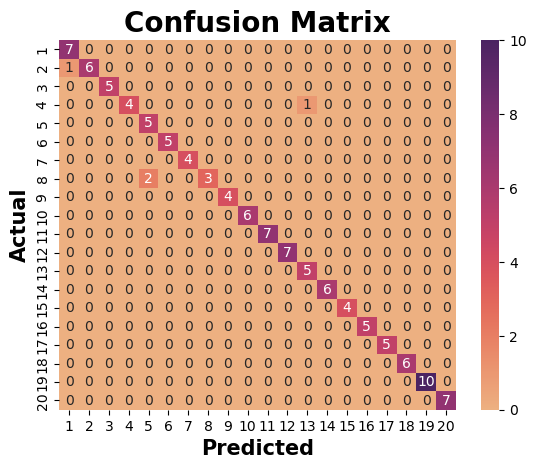

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_258 (Dense)            (None, 128)               29568     
_________________________________________________________________
dense_259 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_260 (Dense)            (None, 20)                1300      
Total params: 39,124
Trainable params: 39,124
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 0s 10ms/step - loss: 13.1707 - accuracy: 0.1246 - val_loss: 6.3000 - val_accuracy: 0.2348
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 4.3261 - accuracy: 0.2899 - val_loss: 2.6561 - val_accuracy: 0.3304
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 1.8214 - accuracy: 0.5275

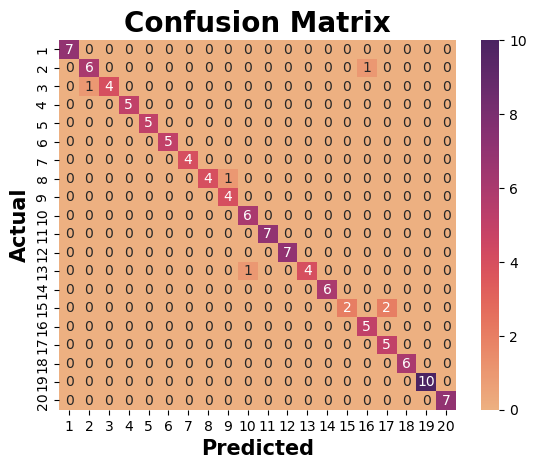

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_261 (Dense)            (None, 128)               30720     
_________________________________________________________________
dense_262 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_263 (Dense)            (None, 20)                1300      
Total params: 40,276
Trainable params: 40,276
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 0s 9ms/step - loss: 30.2426 - accuracy: 0.0609 - val_loss: 14.9736 - val_accuracy: 0.0957
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 9.8405 - accuracy: 0.1855 - val_loss: 6.5358 - val_accuracy: 0.0696
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 4.7777 - accuracy: 0.2377

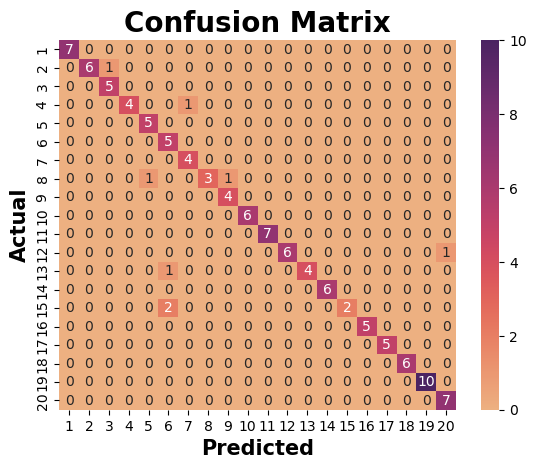

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_264 (Dense)            (None, 128)               31360     
_________________________________________________________________
dense_265 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_266 (Dense)            (None, 20)                1300      
Total params: 40,916
Trainable params: 40,916
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 0s 10ms/step - loss: 25.4405 - accuracy: 0.0464 - val_loss: 10.7625 - val_accuracy: 0.1391
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 7.8857 - accuracy: 0.1826 - val_loss: 4.9476 - val_accuracy: 0.2348
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 3.5794 - accuracy: 0.344

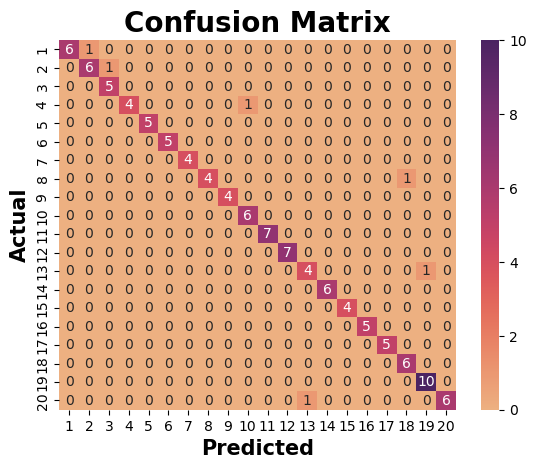

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_267 (Dense)            (None, 128)               31616     
_________________________________________________________________
dense_268 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_269 (Dense)            (None, 20)                1300      
Total params: 41,172
Trainable params: 41,172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 0s 9ms/step - loss: 31.4482 - accuracy: 0.0638 - val_loss: 15.3794 - val_accuracy: 0.0957
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 10.9524 - accuracy: 0.1072 - val_loss: 6.6097 - val_accuracy: 0.2087
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 4.9115 - accuracy: 0.234

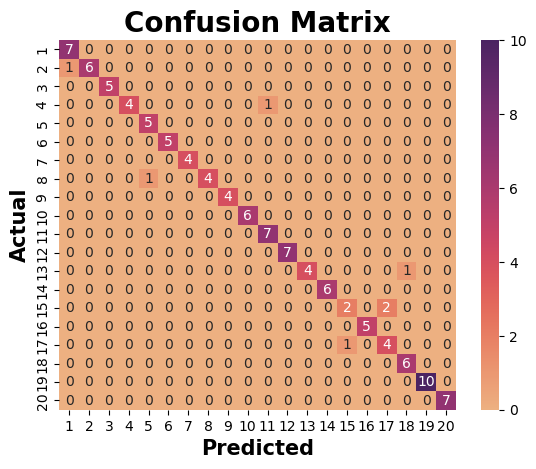

In [145]:
scores = num_cluster_search_mlp_results(pipe, x_train, x_val, x_test, y_train, y_val, y_test, chosen_nums)